# Third Order Cumulant Expansion Method:

#### Obtaining the analytic equations of motion (and print all the variables in the equations of motion):

In [1]:
using QuantumCumulants

# Building the Hilbert space:
(hil_a,hil_b,hil_c) = (FockSpace(:pump),FockSpace(:signal), FockSpace(:idler))
hilbert_space = hil_a ⊗ hil_b ⊗ hil_c

# Defining the operators with labels "a", "b" and "c" in pump, signal and idler subspaces respectively:
(oper_a,oper_b,oper_c)= (Destroy(hilbert_space,:a,1), Destroy(hilbert_space,:b,2), 
                               Destroy(hilbert_space,:c,3))

# Hamiltonian:
hami =im*oper_a*oper_b'*oper_c'-im*oper_a'*oper_b*oper_c

# Finds all the third-order operators:
relev_operators=find_operators(hilbert_space,3)

# Finds all the equations using the third order cumulant expansion:
eqns_motion_analy = meanfield(relev_operators, hami; order=3)

# Printing the variables associated with the equations of motion:
ll=range(1,length(eqns_motion_analy),step=1)
#creating a table:
temp_table = fill("", 48) 
for ii in ll
       temp_table[ii]="$ii: $(eqns_motion_analy[ii].lhs)"
       end
x=reshape(temp_table,(8,6))
Base.print_matrix(stdout, x)

 "1: ⟨a⟩"     "9: ⟨a*a⟩"     "17: ⟨a′*a*b⟩"  "25: ⟨a*a*c⟩"    "33: ⟨a*a*a⟩"    "41: ⟨b*b*b⟩"
 "2: ⟨b⟩"     "10: ⟨b*c⟩"    "18: ⟨a*b′*b⟩"  "26: ⟨a*c*c⟩"    "34: ⟨b′*b*c⟩"   "42: ⟨c′*c′*c⟩"
 "3: ⟨c⟩"     "11: ⟨b′*b⟩"   "19: ⟨a*b*c′⟩"  "27: ⟨a′*a′*a⟩"  "35: ⟨b*c′*c⟩"   "43: ⟨c*c*c⟩"
 "4: ⟨a*b⟩"   "12: ⟨b*c′⟩"   "20: ⟨a*a*b⟩"   "28: ⟨a*b′*c′⟩"  "36: ⟨b*b*c⟩"    ""
 "5: ⟨a*c⟩"   "13: ⟨b*b⟩"    "21: ⟨a*b*b⟩"   "29: ⟨a*a*b′⟩"   "37: ⟨b*c*c⟩"    ""
 "6: ⟨a′*a⟩"  "14: ⟨c′*c⟩"   "22: ⟨a′*a*c⟩"  "30: ⟨a*b′*b′⟩"  "38: ⟨b′*b′*b⟩"  ""
 "7: ⟨a*b′⟩"  "15: ⟨c*c⟩"    "23: ⟨a*b′*c⟩"  "31: ⟨a*a*c′⟩"   "39: ⟨b*b*c′⟩"   ""
 "8: ⟨a*c′⟩"  "16: ⟨a*b*c⟩"  "24: ⟨a*c′*c⟩"  "32: ⟨a*c′*c′⟩"  "40: ⟨b*c′*c′⟩"  ""

#### Setting up parameters and solving the ODE:

In [16]:
using ModelingToolkit
using OrdinaryDiffEq

ALP_SQ = 100  # alpha square
ALP=sqrt(ALP_SQ) ## alpha

# Setting up the time array for evolution:
T_END = 0.380 # Total time of the evolution
DELT_T = 0.001 # Time step for the evolution
t_arr = LinRange(0, T_END,round(Int, T_END / DELT_T) + 1);
################################################################################
# Equations of motion become unstable at longer times, so noting those times
# when they become unstable (to help the user):
#DELT_T=0.001 and T_END=0.380 for ALP_SQ=100
#DELT_T=0.001 and T_END=0.332 for ALP_SQ=163
#DELT_T=0.001 and T_END=0.270 for ALP_SQ=268
#DELT_T=0.001 and T_END=0.220 for ALP_SQ=439
#DELT_T=0.001 and T_END=0.178 for ALP_SQ=719
#DELT_T=0.0005 and T_END=0.156 for ALP_SQ=1000

# Initial conditions for the ODE:
sol_ini = zeros(ComplexF64,43)
sol_ini[1]=ALP
sol_ini[6]=ALP_SQ
sol_ini[9]=ALP_SQ
sol_ini[27]=ALP^3
sol_ini[33]=ALP^3

# Solving the ODEs:
@named system_eqns = ODESystem(eqns_motion_analy)
problem = ODEProblem(system_eqns,sol_ini,(0.0,last(t_arr)));
sol = solve(problem,Tsit5(),abstol=1e-16,reltol=1e-16, saveat = t_arr);

#### 1. Plotting the populations:

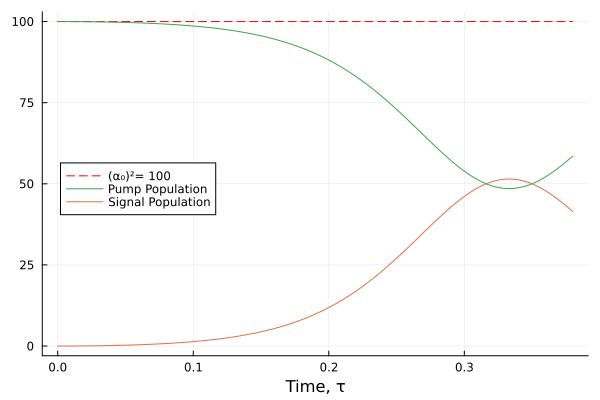

In [17]:
using Plots
plot([0, last(t_arr)], [ALP_SQ, ALP_SQ],ls=:dash,color=:red,label="(α₀)²= $ALP_SQ")
plot!(sol.t,real.(sol[oper_a'*oper_a]),label="Pump Population",color=3)
plot!(sol.t,real.(sol[oper_b'*oper_b]),xlabel="Time, τ",label="Signal Population",legend=:left,color=2)

#### 2. Plotting the pump variance:

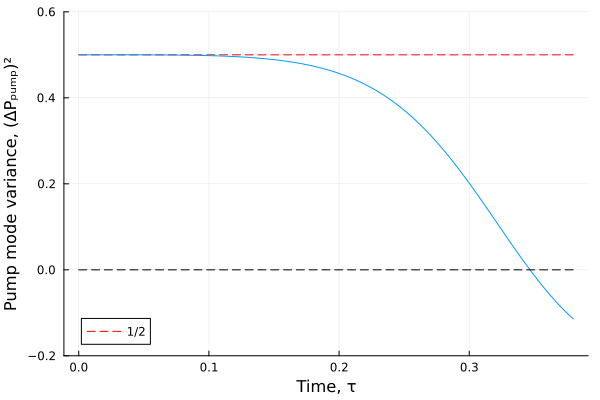

In [18]:
## Eq. C12 in the manuscript:
deltsq_pump_momtm= real.(0.5 .+ sol[oper_a'*oper_a] .- sol[oper_a*oper_a])

plot([0, last(t_arr)], [0.5, 0.5],ls=:dash,color=:red,label="1/2")
plot!(sol.t,deltsq_pump_momtm,label="",xlabel="Time, τ",
                                 ylabel="Pump mode variance, (ΔPₚᵤₘₚ)²",ylims=(-0.2,0.6),color=1)
plot!([0, last(t_arr)], [0.0, 0.0],ls=:dash,color=:black,label="")

#### 3. Zero-delay autocorrelation function:

The autocorrelation functions are given by
\begin{align}
    g^{(2)}_{p}&=\frac{\langle \psi(\tau)|(a^{\dagger})^{2}a^{2}|\psi(\tau)\rangle}{\left(\langle\psi(\tau)| a^{\dagger}a|\psi(\tau)\rangle\right)^{2}}   \\
    g^{(2)}_{s}&=\frac{\langle \psi(\tau)|(b^{\dagger})^{2}b^{2}|\psi(\tau)\rangle}{\left(\langle\psi(\tau)| b^{\dagger}b|\psi(\tau)\rangle\right)^{2}} 
\end{align}
- We have to approximate all the fourth-order moments (numerator terms) in terms of the third and lower-order moments using the cumulant expansion method.

In [7]:
println("⟨(a†)² (a)²⟩ ≈ ",cumulant_expansion(average(oper_a'*oper_a'*oper_a*oper_a),3), "\n")
println("⟨(b†)² (b)²⟩ ≈ ",cumulant_expansion(average(oper_b'*oper_b'*oper_b*oper_b),3))

⟨(a†)² (a)²⟩ ≈ ⟨a′*a′⟩*⟨a*a⟩ + 2⟨a⟩*⟨a′*a′*a⟩ + 2⟨a′⟩*⟨a′*a*a⟩ + 2(⟨a′*a⟩^2) - 2⟨a′*a′⟩*(⟨a⟩^2) - 2⟨a*a⟩*(⟨a′⟩^2) - 8⟨a⟩*⟨a′⟩*⟨a′*a⟩ + 6(⟨a⟩^2)*(⟨a′⟩^2)

⟨(b†)² (b)²⟩ ≈ 2⟨b′⟩*⟨b′*b*b⟩ + 2(⟨b′*b⟩^2) + 2⟨b⟩*⟨b′*b′*b⟩ + ⟨b′*b′⟩*⟨b*b⟩ - 2(⟨b′⟩^2)*⟨b*b⟩ - 8⟨b′⟩*⟨b′*b⟩*⟨b⟩ - 2(⟨b⟩^2)*⟨b′*b′⟩ + 6(⟨b′⟩^2)*(⟨b⟩^2)


- Hence, 
\begin{align}
g^{(2)}_{p} &\approx  \frac{\langle a^{2}\rangle^{2}   +  4\langle a\rangle \langle (a^{\dagger})^{2}a\rangle+ 2 \langle a^{\dagger}a\rangle^{2}  - 4 \langle a \rangle^{2} \langle a^{2}\rangle -8 \langle a\rangle^{2}\langle a^{\dagger}a\rangle + 6 \langle a\rangle^{4}}{{\langle a^{\dagger}a\rangle^{2}}} \\
g^{(2)}_{s} &\approx  2 \frac{\langle b^{\dagger}b\rangle^{2}}{{\langle b^{\dagger}b\rangle^{2}}}=2 \\
\end{align}

#### Plotting autocorrelation function:

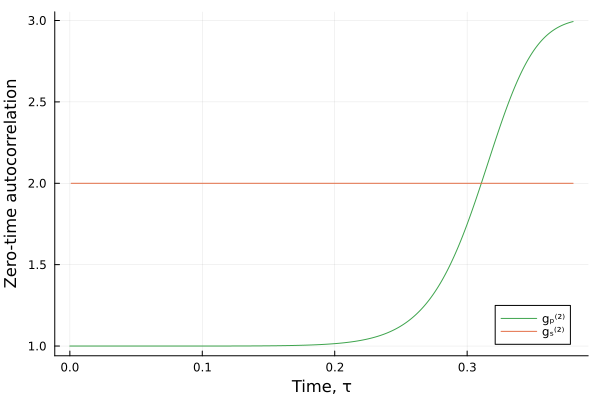

In [22]:
pump_g2_num = real.((sol[oper_a*oper_a].^2) .+ 4 .*(sol[oper_a].*sol[oper_a'*oper_a'*oper_a])
                  .+ 2 .*(sol[oper_a'*oper_a].^2) .- 4 .*((sol[oper_a].^2).*sol[oper_a*oper_a])
                  .- 8 .*((sol[oper_a].^2).*sol[oper_a'*oper_a]) .+ 6 .*(sol[oper_a].^4))

sig_g2_num = real.((sol[oper_b*oper_b].^2) .+ 4 .*(sol[oper_b].*sol[oper_b'*oper_b'*oper_b])
                  .+ 2 .*(sol[oper_b'*oper_b].^2) .- 4 .*((sol[oper_b].^2).*sol[oper_b*oper_b])
                  .- 8 .*((sol[oper_b].^2).*sol[oper_b'*oper_b]) .+ 6 .*(sol[oper_b].^4))

pump_g2=real.(pump_g2_num./ (sol[oper_a'*oper_a].^2))
sig_g2=real.(sig_g2_num./ (sol[oper_b'*oper_b].^2));

plot(sol.t,pump_g2,label="gₚ⁽²⁾",color=3)
plot!(sol.t,sig_g2,label="gₛ⁽²⁾",xlabel="Time, τ", ylabel="Zero-time autocorrelation"
                                                          ,color=2)

#### 4. Exporting all the data (run only if required):

In [10]:
# For writing the data:
#using NPZ
#npzwrite("Cumulant_$(ALP_SQ)_alpha_squared_level3.npy", 
#Dict("time" => sol.t, "pump_population" => real.(sol[oper_a'*oper_a]),
#"signal_population" => real.(sol[oper_b'*oper_b]),"pump_variance_momentum" => deltsq_pump_momtm,
#"pump_g2" => pump_g2, "sig_g2" => sig_g2))